In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Us d'un nou optimitzador.
3. Visualització dels resultats dels filtres convolucionals.

In [9]:
etiquetes = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

train_batch_size = 64
test_batch_size = 100

# Definim una seqüència (composició) de transformacions 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28)
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch
train = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
test = datasets.CIFAR10('../data', train=False, transform=transform)

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)

Files already downloaded and verified


## Definició de la xarxa

### Feina a fer

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:


- `Conv2d`: Capa convolucional en 2 dimensions. Com a paràmetres principals trobarem:

  - in_channels: canals d'entrada.
  - out_channels : canals de sortida (nombre de filtres).
  - kernel_size: mida del filtre.
  - stride: desplaçament del filtre. 
  - padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

- `MaxPool2d`: Capa de max pooling. Aquesta capa no té paràmetres entrenables. Però si:

  - kernel_size: Mida del filtre del qual es seleccionarà el màxim.
  - stride: desplaçament del filtre.

- `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.


- `Linear`

- `ReLU`


2. Per posibilitar la visualització de les imatges passades per les capes convolucionals farem que funció `forward`tengui diverses sortides (diferents valors de `return`) un per cadda capa convolucional de la xarxa.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(7*7*32, 128) #7 * 7 * 64, 120)
        self.linear_2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.conv_1(x)
        x = self.max_pool2d(y)
        z = self.conv_2(x)
        x = self.max_pool2d(z)
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_2(x)

        output = F.log_softmax(x, dim=1)
        return output, y, z

## Entrenament

Això no varia massa de la setmana anterior

### Feina a fer

1. Modificar la sortida de la xarxa, ara retorna diversos valors, encara que aquí només us interessa un.

In [11]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_ , _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

### Adam

Aquesta setmana introduirem un nou algorisme d'optimització anomenat `Adam`. Fins ara hem emprat el descens del gradient (`SGD`). 

`Adam()` és un algorisme d'optimització amplament emprat, tal com el descens del gradient, és iteratiu. A la literatura trobam arguments que indiquen que, tot i que Adam convergeix més ràpidament, SGD  generalitza millor que Adam i, per tant, resulta en un rendiment final millor. 

[Més info](https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008)


### Feina a fer:
1. Mostrar el nombre de paràmetres de la xarxa (també a la xarxa de la setmana passada)
```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```
2. Dibuixar els gràfics de la funció de pèrdua amb les dues funcions d'optimització que coneixem.

In [12]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 15
lr =0.00001

model = Net().to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # !!!

print("Parameters ",pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr) 

# Guardam el valor de peèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_loader)
#567764

Parameters  207210
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.305684, Average: 0.036026
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.308146, Average: 0.036065
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.278955, Average: 0.035609
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.278453, Average: 0.035601
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.267753, Average: 0.035434
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.263324, Average: 0.035364
Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.270611, Average: 0.035478
Train Epoch: 0 [44800/50000 (90%)]	Loss: 2.244366, Average: 0.035068

Train set: Average loss: 0.0356


Test set: Average loss: 0.0223, Accuracy: 2243/10000 (22%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.263963, Average: 0.035374
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.208508, Average: 0.034508
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.144456, Average: 0.033507
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.239061, Average: 0.034985
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.157675, Average: 0.033714
T

Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.788967, Average: 0.027953

Train set: Average loss: 0.0284


Test set: Average loss: 0.0175, Accuracy: 3921/10000 (39%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.848891, Average: 0.028889
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.798380, Average: 0.028100
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.628840, Average: 0.025451
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.891540, Average: 0.029555
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.833369, Average: 0.028646
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.772542, Average: 0.027696
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.926545, Average: 0.030102
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.727270, Average: 0.026989

Train set: Average loss: 0.0282


Test set: Average loss: 0.0174, Accuracy: 3954/10000 (40%)

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.848994, Average: 0.028891
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.799333, Average: 0.028115
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.640666, 

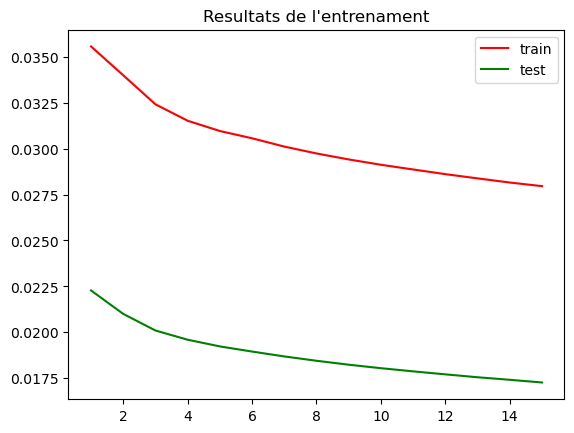

In [13]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el groun truth com a títol de la imatge.
3. Visualitzar el resultat de la mateixa imatge passada per tots els filtres de cada convolució de la vostra xarxa.
4. **Extra**: Fer la matriu de confusió de les 10 classes per poder entendre el que no estau fent bé (la xarxa no està fent bé).

A tenir en compte:

#### Subplots

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

#### Device

Si heu emprat _GPU_ per accelerar el procés d'entrenament, els resultats que obtenim de la xarxa també seràn a la _GPU_. **Pytorch** proporciona la funció `cpu()` que retorna una còpia d'aquest objecte a la memòria de la CPU.

#### Detach
Per poder operar amb els resultats de la predicció emprarem la funció `detach` que retorna un nou Tensor "separat" del graf (xarxa) en curs.

Per tant per transformar el tensor que retorna la xarxa en un array de la lliberia _Numpy_ caldria fer el següent:

  ```
  resultat_np = resultat.detach().numpy()
  ```
Si a més hem executat l'entrenament en _GPU_:
  ```
  resultat_np = resultat.cpu().detach().numpy()
  ```


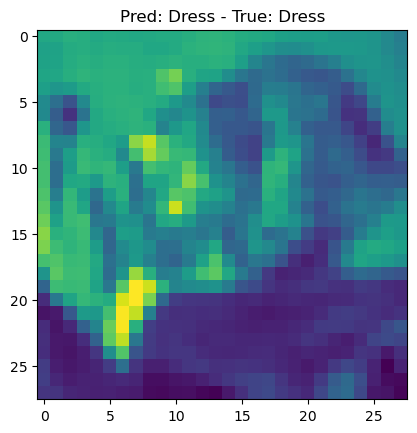

In [14]:
def generador(loader):
  for data, target in test_loader:

    yield data, target

gen = generador(test_loader)

tst, true_labels = next(gen)
data = tst
model.eval()
output, f1, f2 = model(data)

labels = output.detach().numpy()
images = tst.numpy()
labels = np.argmax(labels, axis=1)

plt.title(f'Pred: {etiquetes[labels[0]]} - True: {etiquetes[int(true_labels[0])]}')
plt.imshow(images[0,0,:,:])
plt.show()

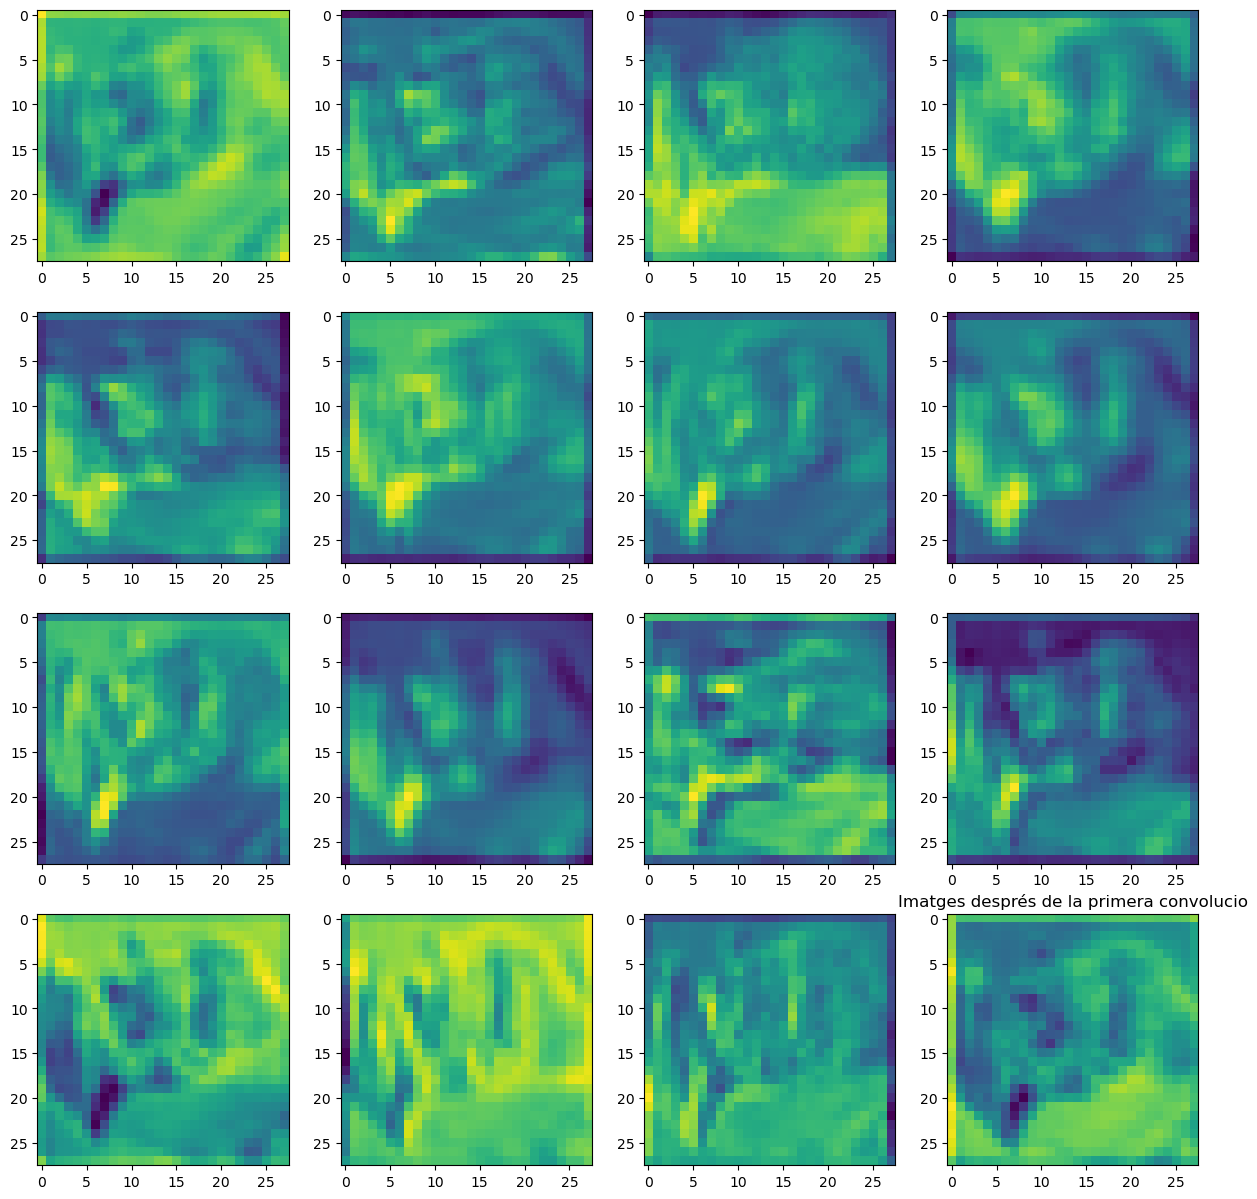

In [15]:
rows= 4
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
        if img_count < rows*cols:
            axes[i, j].imshow(f1.detach().numpy()[0,img_count,:,:])
            
            img_count+=1
            
plt.title("Imatges després de la primera convolucio")
plt.show()

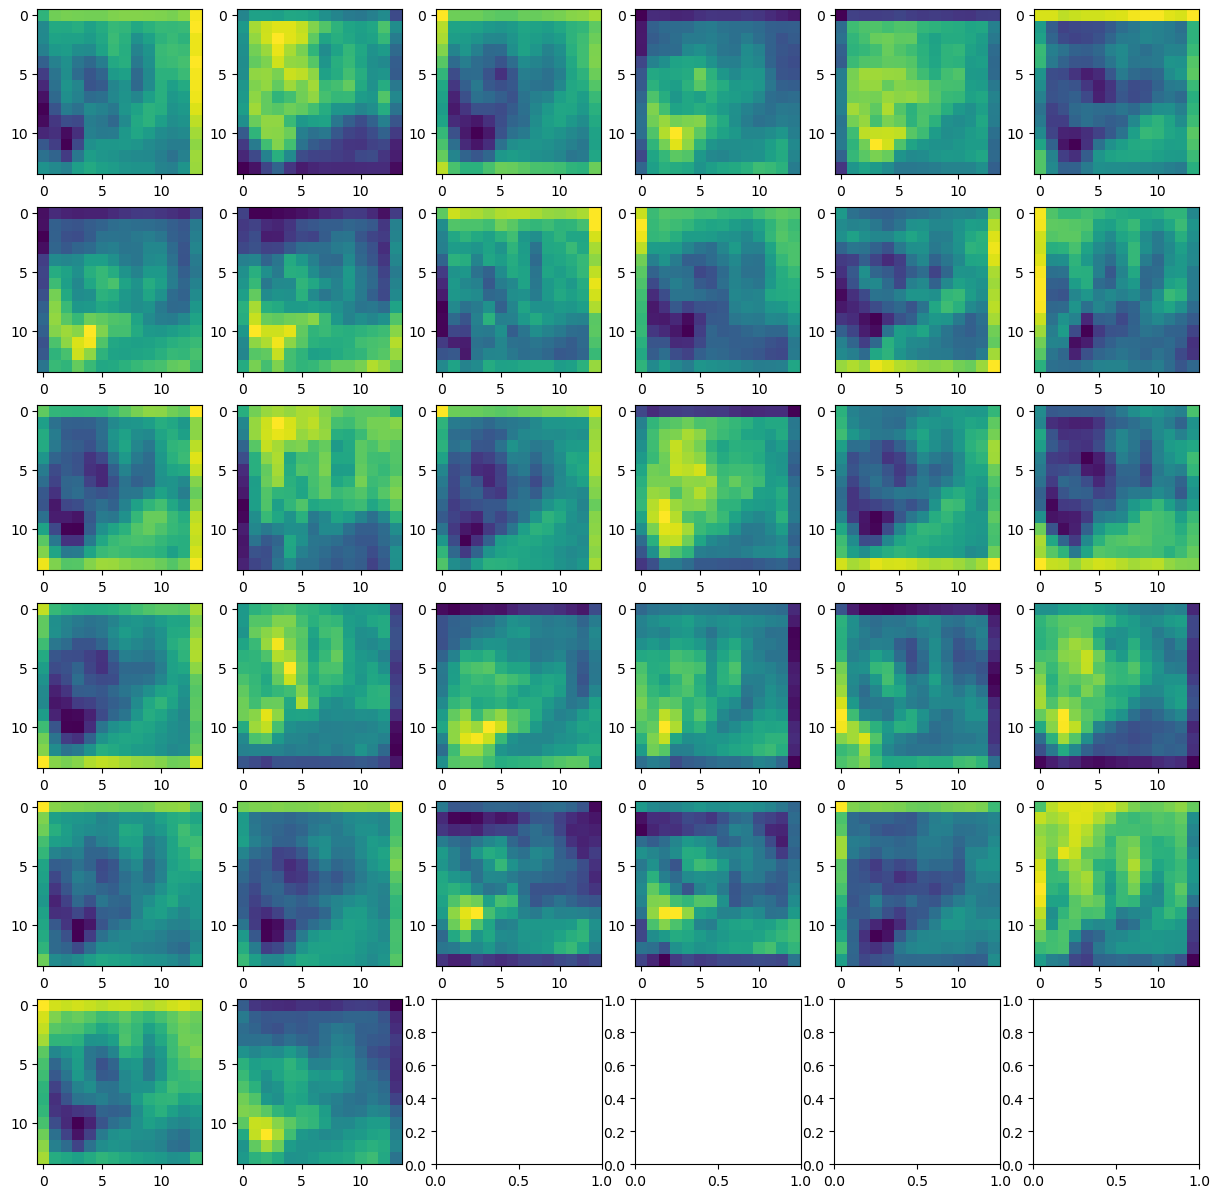

In [16]:
rows= 6
cols = 6
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
        if img_count < 32:#rows * cols:
            axes[i, j].imshow(f2.detach().numpy()[0,img_count,:,:])
            
            img_count+=1
plt.show()